# Visualizing what happens to data at hidden layers

In this notebook we will continue the paradigm of feeding 3D data point cloud consisting of two interlinked tori, and being trained to classify one subset from the other. Here's a few differences:

- I will also try to classify two datasets that are completely within one another, like a bicycle tire and an inner tube. 
- Noticed that there was a problem with continuity. The interlinked tori couldn't be fully separated, only stretched, because the neural network operations are all continuous, so one couldn't shear the cloud of data points. Will try to introduce some discontinuities.
- Will graph the learning rates of various architectures. Depth and Width.


First let's write functions that produce the data points, as well as visualize them.

## Creating and Visualizing the Synthetic Data

In [2]:
import numpy as np

# Random Point Generator for the points on the
# surface of a torus with radii R and r.
def rpg(R, r, N):
    #two random angles are chosen
    theta1 = 2*np.pi*np.random.rand(N)
    theta2 = 2*np.pi*np.random.rand(N)
    sr = r*np.ones(N)
    #define a rotator matrix for each theta in the array theta2
    Roty = np.array(list(map(lambda x: rot(x, axis = 'y'), theta2)))
    #now create a set of points of the form (r, 0, 0)^t
    prerot = np.zeros((N,3))
    prerot[:,0] = sr
    #and rotate them according to the corresponding theta2 angles
    addpoints = np.array(list(map(lambda x, y: x.dot(y), Roty, prerot)))
    #Now add these points to (R,0,0)^t, 
    #then rotate them according to angles in theta1 around  axis
    Rotz = np.array(list(map(rot, theta1)))
    prerot2 = np.zeros((N,3))
    prerot2[:,0] = R*np.ones(N)
    prerot2 += addpoints
    points = np.array(list(map(lambda x,y: x.dot(y), Rotz, prerot2))) 
    return points


# Random Point Generator for points that have the body of the torus
# where first points are picked from a 3D gaussian with Mean (R,0,0)
# Standard Deviation r, and later rotated on the z axis with a random angle.

def rpg2(R,r,N):
    points = r*np.random.multivariate_normal(mean = [R,0,0], cov = np.identity(3), size = N)
    thetas = 2*np.pi*np.random.rand(N)
    Rots = np.array(list(map(rot, thetas)))
    for i in np.arange(N):
        points[i] = points[i].dot(Rots[i])
    return points

def rot(theta, axis = 'z'):
    c, s = np.cos(theta), np.sin(theta)
    if axis == 'z':
        R = np.array(((c,-s,0),(s,c,0),(0,0,1)))
    if axis == 'y':
        R = np.array(((c, 0, -s), (0,1,0),(s,0,c)))
    if axis == 'x':
        R = np.array(((1,0,0),(0,c,-s),(0,s,c)))
    return R


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# This function visualizes 3D data points colored red or blue.
# Input is a list xs of points in 3D Euclidean space and another
# list ys of the same length where each entry is [0,1] or [0,1].
# The ys provides the coloring of the xs via their list index.
def dataVisualizer(xs, ys):
    BluePoints = xs[list(map(lambda a: list(a)==[1,0], ys))]
    RedPoints = xs[list(map(lambda a: list(a)==[0,1], ys))]
    bxs, bys, bzs = BluePoints.transpose(0,1)
    rxs, rys, rzs = RedPoints.transpose(0,1)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(rxs, rys, rzs, s = 0.1, c = 'red', marker='o', alpha = 0.1)
    ax.scatter(bxs, bys, bzs, s = 0.1, c = 'blue', marker = 'o', alpha = 0.1)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

    

Now let us create two types of data. One of them will again be the interlinked tori. The other one will be two tori surfaces that are inside one another, like a bicycle tire and its inner tube.

In [3]:
import torch
import torch.tensor as tt
import torch.nn as nn
import torch.nn.functional as F

# This two functions create a set of points and labels,
# with N1 blue points labeled [1,0] and N2 red points labeled [0,1]

# This is the data that produces 
def dataCreatorLinkedTori(R, r, N1, N2):
    BluePoints = rpg2(R,r,N1)
    RedPoints = rpg2(R,r,N2)
    Rot = rot(np.pi/2, axis = 'y')
    RedPoints = np.array(list(map(lambda x: Rot.dot(x) + np.array([0,R,0]),RedPoints)))
    X = torch.cat((tt(BluePoints, dtype = torch.float), tt(RedPoints, dtype=torch.float)),0)
    Y = torch.cat((tt([1,0], dtype=torch.float).repeat(N1,1), tt([0,1], dtype=torch.float).repeat(N2,1)),0)
    return X,Y

def dataCreatorSheath(R,r1, r2, N1, N2):
    BluePoints = rpg(R,r1,N1)
    RedPoints = rpg(R,r2, N2)
    X = torch.cat((tt(BluePoints, dtype = torch.float), tt(RedPoints, dtype=torch.float)), 0 )
    Y = torch.cat((tt([1,0], dtype=torch.float).repeat(N1,1), tt([0,1], dtype=torch.float).repeat(N2,1)),0)
    return X,Y
    

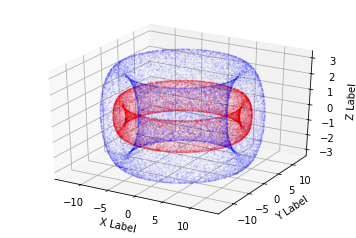

In [4]:
x_train, y_train = dataCreatorSheath(10,3,1,30000,30000)
x_test, y_test = dataCreatorSheath(10,3,1,3000,3000)

dataVisualizer(x_train,y_train)

This is very easy for us humans to separate, you can solve it using analytic geometry: If your data point $(x,y,z)$ has distance $1$ to the circle $\{(x,y,0): \sqrt{x^2 + y^2} =10\}$, then it is a red point; if he distance is 3, then you have a blue point. But I don't think any neural network based on continuous functions deforming the data could separate these two.

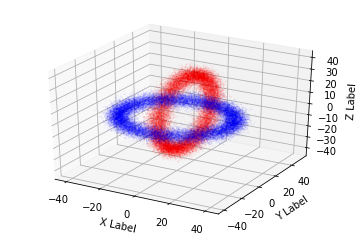

In [23]:
x_train2, y_train2 = dataCreatorLinkedTori(10,3,30000,30000)
x_test2, y_test2 = dataCreatorLinkedTori(10,3,3000,3000)

dataVisualizer(x_train2, y_train2)

I wanted to be able to see the two datasets more clearly, and I didn't bother with making the marks large, so instead I added more data points. I ended up putting 60k data points. This is the same number of data points as MNIST traning set. And that is 784 dimensional, whereas this is in 3d. I wonder if overfilling a small dimensional space with way too many points gives rise to different phenomena. If I picked, say, about 230 training samples (chosen since $\frac{60k}{728} \sim \frac{230}{3})$, how would it perform? Could it possibly perform better because with gaps in the coverage, it is possible for the network to find an opening to put the decision boundary through?

## Training a Neural Network to Classify

We now train networks of various depth and width that classify red and blue points. 

We will also try to see visually how is the data distorted/stretched in the middle layers. For the sheath/sleeve/inner tube data set I suspect we need to introduce some nonlinearity in the activation function, or perhaps better the bias. I say bias is better because the gap in the jump needs to be learned as well. So perhaps what we want is
$$
\operatorname{ReLU}(W x + b + b' H(x))
$$
where $H(x) = \begin{cases} 0 &\text{ if } x \leq 0\\ 1 &\text{ if } x>0\end{cases}$ is the Heaviside function.

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, input_dim=3, width=3, depth=4, num_classes=2):
        super(FullyConnected, self).__init__()
        self.input_dim = input_dim
        self.width = width
        self.depth = depth
        self.num_classes = num_classes    
       
        layers = []
        layers.append(nn.Linear(self.input_dim, self.width))
        layers.append(nn.ReLU())
        for i in range(self.depth - 2):
            layers.append(nn.Linear(self.width, self.width))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.width, self.num_classes))
        # I added a softmax layer, recall that somehow it wasn't learning w/o this one.
        layers.append(nn.Softmax(dim = -1))
        self.net = nn.Sequential(*layers)
 
    def forward(self, x):
        # hocam bu alttaki satır çok manasız geldi, zaten biz 3 boyutlu veri
        # gireceğiz, gerekmiyor da, gerekse de çalışmaması gerekmiyor mu?
        # x nasil bir girdi senin kafanda? 28*28 bir resim değil mi?
        # x = x.view(x.size(0), self.input_dim)
        x = self.net(x)
        return x



In [7]:
# We now create various fully connected networks 
# I found it easier to collect all of them in a dictionary
depths = np.array([4,10,40,100])
widths = np.array([3,10,30,100])

def cartesian_product(x,y):
     return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

network_sizes =  cartesian_product(depths, widths)

networks = {}
for (depth,width) in network_sizes:
    networks['net{0}d{1}w'.format(depth, width)] = FullyConnected(width = width, depth = depth)

networks

{'net4d3w': FullyConnected(
   (net): Sequential(
     (0): Linear(in_features=3, out_features=3, bias=True)
     (1): ReLU()
     (2): Linear(in_features=3, out_features=3, bias=True)
     (3): ReLU()
     (4): Linear(in_features=3, out_features=3, bias=True)
     (5): ReLU()
     (6): Linear(in_features=3, out_features=2, bias=True)
     (7): Softmax(dim=-1)
   )
 ), 'net10d3w': FullyConnected(
   (net): Sequential(
     (0): Linear(in_features=3, out_features=3, bias=True)
     (1): ReLU()
     (2): Linear(in_features=3, out_features=3, bias=True)
     (3): ReLU()
     (4): Linear(in_features=3, out_features=3, bias=True)
     (5): ReLU()
     (6): Linear(in_features=3, out_features=3, bias=True)
     (7): ReLU()
     (8): Linear(in_features=3, out_features=3, bias=True)
     (9): ReLU()
     (10): Linear(in_features=3, out_features=3, bias=True)
     (11): ReLU()
     (12): Linear(in_features=3, out_features=3, bias=True)
     (13): ReLU()
     (14): Linear(in_features=3, out_featu

In [8]:
for network_name in networks:
    print(network_name, '\t width: ', networks[network_name].width, "\t depth: ", networks[network_name].depth)

net4d3w 	 width:  3 	 depth:  4
net10d3w 	 width:  3 	 depth:  10
net40d3w 	 width:  3 	 depth:  40
net100d3w 	 width:  3 	 depth:  100
net4d10w 	 width:  10 	 depth:  4
net10d10w 	 width:  10 	 depth:  10
net40d10w 	 width:  10 	 depth:  40
net100d10w 	 width:  10 	 depth:  100
net4d30w 	 width:  30 	 depth:  4
net10d30w 	 width:  30 	 depth:  10
net40d30w 	 width:  30 	 depth:  40
net100d30w 	 width:  30 	 depth:  100
net4d100w 	 width:  100 	 depth:  4
net10d100w 	 width:  100 	 depth:  10
net40d100w 	 width:  100 	 depth:  40
net100d100w 	 width:  100 	 depth:  100


We now train each of these networks using the same method I used (which looks kinda pedestrian to be honest, but I'll pass on sleekness for understandability)

In [9]:
import torch.optim as optim
learning_rate = 0.001

# create a stochastic gradient descent optimizer that uses Mean Square Error Loss

def train(network, trainloader, epoch_no = 2, learning_rate = 0.01, momentum = 0.9):
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
    criterion = nn.MSELoss()
    for epoch in range(epoch_no):  
        running_loss = 0.0
        for i, data in enumerate(trainloader,0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 1000 == 999:    # print every 1000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0
    
    print('Finished Training')

In [27]:
trainset = list(zip(x_train, y_train))
testset = list(zip(x_test, y_test))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

In [11]:
for network_name in networks:
    print(network_name)
    train(networks[network_name], trainloader)

net4d3w
[1,  1000] loss: 0.252
[1,  2000] loss: 0.251
[1,  3000] loss: 0.251
[1,  4000] loss: 0.251
[1,  5000] loss: 0.251
[1,  6000] loss: 0.251
[1,  7000] loss: 0.251
[1,  8000] loss: 0.251
[1,  9000] loss: 0.251
[1, 10000] loss: 0.251
[1, 11000] loss: 0.251
[1, 12000] loss: 0.251
[1, 13000] loss: 0.250
[1, 14000] loss: 0.251
[1, 15000] loss: 0.251
[2,  1000] loss: 0.250
[2,  2000] loss: 0.251
[2,  3000] loss: 0.251
[2,  4000] loss: 0.251
[2,  5000] loss: 0.251
[2,  6000] loss: 0.251
[2,  7000] loss: 0.251
[2,  8000] loss: 0.251
[2,  9000] loss: 0.250
[2, 10000] loss: 0.251
[2, 11000] loss: 0.250
[2, 12000] loss: 0.243
[2, 13000] loss: 0.211
[2, 14000] loss: 0.208
[2, 15000] loss: 0.205
Finished Training
net10d3w
[1,  1000] loss: 0.252
[1,  2000] loss: 0.251
[1,  3000] loss: 0.251
[1,  4000] loss: 0.251
[1,  5000] loss: 0.251
[1,  6000] loss: 0.251
[1,  7000] loss: 0.251
[1,  8000] loss: 0.251
[1,  9000] loss: 0.251
[1, 10000] loss: 0.251
[1, 11000] loss: 0.251
[1, 12000] loss: 0.251

[1, 14000] loss: 0.251
[1, 15000] loss: 0.251
[2,  1000] loss: 0.251
[2,  2000] loss: 0.251
[2,  3000] loss: 0.251
[2,  4000] loss: 0.251
[2,  5000] loss: 0.251
[2,  6000] loss: 0.251
[2,  7000] loss: 0.251
[2,  8000] loss: 0.251
[2,  9000] loss: 0.251
[2, 10000] loss: 0.251
[2, 11000] loss: 0.251
[2, 12000] loss: 0.251
[2, 13000] loss: 0.251
[2, 14000] loss: 0.251
[2, 15000] loss: 0.251
Finished Training
net4d100w
[1,  1000] loss: 0.192
[1,  2000] loss: 0.139
[1,  3000] loss: 0.132
[1,  4000] loss: 0.123
[1,  5000] loss: 0.125
[1,  6000] loss: 0.119
[1,  7000] loss: 0.117
[1,  8000] loss: 0.120
[1,  9000] loss: 0.113
[1, 10000] loss: 0.121
[1, 11000] loss: 0.122
[1, 12000] loss: 0.122
[1, 13000] loss: 0.124
[1, 14000] loss: 0.114
[1, 15000] loss: 0.116
[2,  1000] loss: 0.116
[2,  2000] loss: 0.120
[2,  3000] loss: 0.111
[2,  4000] loss: 0.108
[2,  5000] loss: 0.122
[2,  6000] loss: 0.114
[2,  7000] loss: 0.112
[2,  8000] loss: 0.114
[2,  9000] loss: 0.122
[2, 10000] loss: 0.109
[2, 11

Ok, the results are interesting, even before I plot what happened to the representation in the in-between layers. This is the sleeve dataset. I am surprised that you could learn it, even though it was learned badly. The deeper the network, the worse the learning outcome it seems. The best outcomes were for those networks that had depth 4, and the loss is about 0.1 (the worst loss is 0.25, which is basically chance). Except that something magical happens for depth $4$ and width $30$ and you get perfect match, but then you lose it again to go back to about $0.10\sim0.11$ loss for width 100. (Is 30 somehow the jamming transition region that was talked at length about in your conference, if so then I expect width 30 to perform the worst among those of depth 4 in the test_set. We'll see in a short while. All in good time sir, all in good time. No need to get ahead of ourselves.)

The only other network that seems to "learn" anything is the depth 10 and width 100 network. Could that have also hit a sweet spot?

The reason I'm putting "learn" in quotes is because I'm suspecting they've memorized the training set somehow, and haven't learned anything.

> When I wrote the cell above, the net4d3w network had learned better. This time the error seems to have gotten stuck in the beginning, only becoming better in the latter half of the second epoch. So I will train that one again. Also the 4d30w network didn't train perfectly this time, but still better than the rest of the depth 4 networks.

In [17]:
train(networks['net4d3w'], trainloader)
train(networks['net4d30w'], trainloader)

[1,  1000] loss: 0.101
[1,  2000] loss: 0.099
[1,  3000] loss: 0.104
[1,  4000] loss: 0.096
[1,  5000] loss: 0.101
[1,  6000] loss: 0.105
[1,  7000] loss: 0.097
[1,  8000] loss: 0.099
[1,  9000] loss: 0.101
[1, 10000] loss: 0.104
[1, 11000] loss: 0.096
[1, 12000] loss: 0.101
[1, 13000] loss: 0.107
[1, 14000] loss: 0.105
[1, 15000] loss: 0.099
[2,  1000] loss: 0.100
[2,  2000] loss: 0.097
[2,  3000] loss: 0.101
[2,  4000] loss: 0.108
[2,  5000] loss: 0.091
[2,  6000] loss: 0.107
[2,  7000] loss: 0.100
[2,  8000] loss: 0.096
[2,  9000] loss: 0.099
[2, 10000] loss: 0.096
[2, 11000] loss: 0.099
[2, 12000] loss: 0.104
[2, 13000] loss: 0.098
[2, 14000] loss: 0.102
[2, 15000] loss: 0.101
Finished Training
[1,  1000] loss: 0.058
[1,  2000] loss: 0.072
[1,  3000] loss: 0.049
[1,  4000] loss: 0.037
[1,  5000] loss: 0.029
[1,  6000] loss: 0.049
[1,  7000] loss: 0.019
[1,  8000] loss: 0.001
[1,  9000] loss: 0.000
[1, 10000] loss: 0.000
[1, 11000] loss: 0.000
[1, 12000] loss: 0.000
[1, 13000] loss:

In [18]:
def percentIncorrect(net, x_test, y_test):
    guesses = list(map(lambda a: net(a).argmax().item(), x_test))
    results = list(map(lambda a: a.argmax().item(), y_test))
    return ((np.array(guesses)  - np.array(results))**2).mean()
    
for network_name in networks:
    print(network_name)
    print(percentIncorrect(networks[network_name], x_test, y_test))

net4d3w
0.13133333333333333
net10d3w
0.5
net40d3w
0.5
net100d3w
0.5
net4d10w
0.13016666666666668
net10d10w
0.5
net40d10w
0.5
net100d10w
0.5
net4d30w
0.0
net10d30w
0.12716666666666668
net40d30w
0.5
net100d30w
0.5
net4d100w
0.13766666666666666
net10d100w
0.15233333333333332
net40d100w
0.5
net100d100w
0.5


Ekmek mushaf çarpsın I made my forecast before running this test set. And ahanda you have it. The depth $4$ width $10$ network, which performed spectacularly with $0.00$ loss on the training set, flunked on the test set. The other networks which learned anything learned with about $84\%$ accuracy. (I'm surprised they could learn this at all, for a continuous function it seems really hard, there's now way for the red set to get out of the blue one).

My prediction about the net10d100w was wrong though, or it is not clear. We might want to test out more widths at the depth 10 mark.

Now let us teach the linked tori.

> This time, obviously something else happened, and I trained the net4d30w some more epochs, and it perfectly learned to do this on the test set. I really need to see this. How is this possible. And also why at width 30? Is there a sweet spot. I am having a guess that de deeper you go the flatter your loss function looks in the parameter space, but why is there a sweet spot (at least in the training, but this time also in the test set) as you go wider? If it was only the training set, I'd be happier to be honest, but there is contingency on the random parameters it runs on each time. 

In [31]:
# Now the second data set, let's not retrain the old networks,
# instead create new instacnes of the fully connected networks.

depths2 = np.array([4,10,40,100])
widths2 = np.array([3,10,30,100])

network_sizes2 =  cartesian_product(depths, widths2)

networks2 = {}
for (depth2,width2) in network_sizes2:
    networks2['2net{0}d{1}w'.format(depth2, width2)] = FullyConnected(width = width2, depth = depth2)
    
trainset2 = list(zip(x_train2, y_train2))
testset2 = list(zip(x_test2, y_test2))

trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=4, shuffle=True)
testloader2 = torch.utils.data.DataLoader(testset2, batch_size=4, shuffle=True)

In [32]:
for network_name2 in networks2:
    print(network_name2)
    train(networks2[network_name2], trainloader2)

2net4d3w
[1,  1000] loss: 0.148
[1,  2000] loss: 0.065
[1,  3000] loss: 0.052
[1,  4000] loss: 0.050
[1,  5000] loss: 0.049
[1,  6000] loss: 0.054
[1,  7000] loss: 0.046
[1,  8000] loss: 0.042
[1,  9000] loss: 0.049
[1, 10000] loss: 0.045
[1, 11000] loss: 0.048
[1, 12000] loss: 0.048
[1, 13000] loss: 0.045
[1, 14000] loss: 0.046
[1, 15000] loss: 0.051
[2,  1000] loss: 0.054
[2,  2000] loss: 0.046
[2,  3000] loss: 0.052
[2,  4000] loss: 0.043
[2,  5000] loss: 0.052
[2,  6000] loss: 0.059
[2,  7000] loss: 0.052
[2,  8000] loss: 0.054
[2,  9000] loss: 0.048
[2, 10000] loss: 0.042
[2, 11000] loss: 0.049
[2, 12000] loss: 0.063
[2, 13000] loss: 0.057
[2, 14000] loss: 0.044
[2, 15000] loss: 0.045
Finished Training
2net10d3w
[1,  1000] loss: 0.251
[1,  2000] loss: 0.251
[1,  3000] loss: 0.251
[1,  4000] loss: 0.251
[1,  5000] loss: 0.251
[1,  6000] loss: 0.251
[1,  7000] loss: 0.226
[1,  8000] loss: 0.110
[1,  9000] loss: 0.192
[1, 10000] loss: 0.186
[1, 11000] loss: 0.181
[1, 12000] loss: 0.1

[1, 14000] loss: 0.250
[1, 15000] loss: 0.251
[2,  1000] loss: 0.251
[2,  2000] loss: 0.251
[2,  3000] loss: 0.251
[2,  4000] loss: 0.250
[2,  5000] loss: 0.251
[2,  6000] loss: 0.251
[2,  7000] loss: 0.251
[2,  8000] loss: 0.251
[2,  9000] loss: 0.251
[2, 10000] loss: 0.251
[2, 11000] loss: 0.251
[2, 12000] loss: 0.251
[2, 13000] loss: 0.251
[2, 14000] loss: 0.251
[2, 15000] loss: 0.251
Finished Training
2net4d100w
[1,  1000] loss: 0.047
[1,  2000] loss: 0.038
[1,  3000] loss: 0.036
[1,  4000] loss: 0.034
[1,  5000] loss: 0.036
[1,  6000] loss: 0.034
[1,  7000] loss: 0.031
[1,  8000] loss: 0.032
[1,  9000] loss: 0.032
[1, 10000] loss: 0.032
[1, 11000] loss: 0.031
[1, 12000] loss: 0.031
[1, 13000] loss: 0.032
[1, 14000] loss: 0.031
[1, 15000] loss: 0.033
[2,  1000] loss: 0.033
[2,  2000] loss: 0.029
[2,  3000] loss: 0.031
[2,  4000] loss: 0.029
[2,  5000] loss: 0.028
[2,  6000] loss: 0.029
[2,  7000] loss: 0.027
[2,  8000] loss: 0.032
[2,  9000] loss: 0.030
[2, 10000] loss: 0.029
[2, 1

In [34]:
# I want to continue training the 2net10d3w a bit more,
# I think it should perform well but maybe with more training?
# This is because of my previous notebook, I've seen that it can learn this.

train(networks2['2net10d3w'],trainloader2)

[1,  1000] loss: 0.184
[1,  2000] loss: 0.182
[1,  3000] loss: 0.182
[1,  4000] loss: 0.183
[1,  5000] loss: 0.187
[1,  6000] loss: 0.191
[1,  7000] loss: 0.186
[1,  8000] loss: 0.184
[1,  9000] loss: 0.183
[1, 10000] loss: 0.191
[1, 11000] loss: 0.186
[1, 12000] loss: 0.181
[1, 13000] loss: 0.185
[1, 14000] loss: 0.177
[1, 15000] loss: 0.183
[2,  1000] loss: 0.187
[2,  2000] loss: 0.185
[2,  3000] loss: 0.181
[2,  4000] loss: 0.182
[2,  5000] loss: 0.181
[2,  6000] loss: 0.181
[2,  7000] loss: 0.183
[2,  8000] loss: 0.185
[2,  9000] loss: 0.181
[2, 10000] loss: 0.185
[2, 11000] loss: 0.184
[2, 12000] loss: 0.178
[2, 13000] loss: 0.182
[2, 14000] loss: 0.182
[2, 15000] loss: 0.183
Finished Training


Ok Not much difference in the second time round.

Now we visualize what is happening in the middle layers, for this purpose we have to get out the values it produces in the intermediate layers. I'm going to use the hook functionality you sent me, essentially copying and pasting from (this useful tutorial)[https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/] on hooks. I don't really understand how they work, so let's just see them in action and test whether they do what I think they do.

In [118]:
representation = {}

def hook_fn(module, inp, out):
  representation[module] = out

#This is what the website had, assuming perhaps that you could have some nn.Sequential and 
#maybe more nn.Sequential's nested inside etc. etc. 
def get_values_from_layers(net):
  for name, layer in net._modules.items():
    #If it is a sequential, don't register a hook on it
    # but recursively register hook on all it's module children
    if isinstance(layer, nn.Sequential):
      get_values_from_layers(layer)
    else:
      # it's a non sequential. Register a hook
      layer.register_forward_hook(hook_fn)

testnet = networks['net4d3w']

get_values_from_layers(testnet)


testnet(x_train)


# Just to check whether we got all layers
representation.keys()      #output includes sequential layers

dict_keys([Linear(in_features=3, out_features=3, bias=True), ReLU(), Linear(in_features=3, out_features=3, bias=True), ReLU(), Linear(in_features=3, out_features=3, bias=True), ReLU(), Linear(in_features=3, out_features=2, bias=True), Softmax(dim=-1)])

In [58]:
representation

{Linear(in_features=3, out_features=3, bias=True): tensor([[-23.6010,  23.1983, -22.0049],
         [ 10.3215, -25.3938,   8.7929],
         [  8.1230, -22.4381,   6.7513],
         ...,
         [ -3.2458,  -4.7598,  -3.6043],
         [  2.8743, -15.2672,   1.9865],
         [  3.2617, -13.6142,   2.3333]], grad_fn=<AddmmBackward>),
 ReLU(): tensor([[ 0.0000, 23.1983,  0.0000],
         [10.3215,  0.0000,  8.7929],
         [ 8.1230,  0.0000,  6.7513],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 2.8743,  0.0000,  1.9865],
         [ 3.2617,  0.0000,  2.3333]], grad_fn=<ReluBackward0>),
 Linear(in_features=3, out_features=3, bias=True): tensor([[34.4603, -5.0730, -0.1608],
         [15.3830, -1.2056, -8.4487],
         [11.0098, -0.9597, -6.6020],
         ...,
         [-4.3605, -0.1550, -0.2181],
         [ 0.6781, -0.3871, -2.2540],
         [ 1.4358, -0.4288, -2.5722]], grad_fn=<AddmmBackward>),
 ReLU(): tensor([[34.4603,  0.0000,  0.0000],
         [15.3830,  0

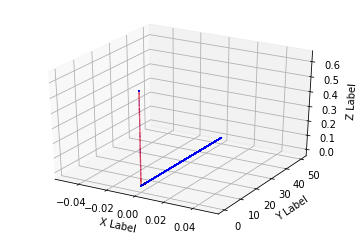

In [142]:
transformedpoints1 = list(representation.items())[5][1].detach()
dataVisualizer(transformedpoints1, y_train)

In [101]:
net3d3w = FullyConnected(width = 3, depth = 3)
net4d3w = FullyConnected(width = 3, depth = 4)
net5d3w = FullyConnected(width = 3, depth = 5)
net6d3w = FullyConnected(width = 3, depth = 6)
net7d3w = FullyConnected(width = 3, depth = 7)

In [143]:
print('net3d3w')
train(net3d3w, trainloader)
print('net4d3w')
train(net4d3w, trainloader)
print('net5d3w')
train(net5d3w, trainloader)
print('net6d3w')
train(net6d3w, trainloader)
print('net7d3w')
train(net7d3w, trainloader)

net3d3w
[1,  1000] loss: 0.103
[1,  2000] loss: 0.104
[1,  3000] loss: 0.109
[1,  4000] loss: 0.105
[1,  5000] loss: 0.106
[1,  6000] loss: 0.110
[1,  7000] loss: 0.095
[1,  8000] loss: 0.103
[1,  9000] loss: 0.106
[1, 10000] loss: 0.113
[1, 11000] loss: 0.103
[1, 12000] loss: 0.103
[1, 13000] loss: 0.100
[1, 14000] loss: 0.112
[1, 15000] loss: 0.108
[2,  1000] loss: 0.105
[2,  2000] loss: 0.104
[2,  3000] loss: 0.111
[2,  4000] loss: 0.101
[2,  5000] loss: 0.104
[2,  6000] loss: 0.108
[2,  7000] loss: 0.107
[2,  8000] loss: 0.104
[2,  9000] loss: 0.103
[2, 10000] loss: 0.098
[2, 11000] loss: 0.102
[2, 12000] loss: 0.102
[2, 13000] loss: 0.106
[2, 14000] loss: 0.095
[2, 15000] loss: 0.104
Finished Training
net4d3w
[1,  1000] loss: 0.136
[1,  2000] loss: 0.133
[1,  3000] loss: 0.126
[1,  4000] loss: 0.132
[1,  5000] loss: 0.127
[1,  6000] loss: 0.128
[1,  7000] loss: 0.131
[1,  8000] loss: 0.129
[1,  9000] loss: 0.134
[1, 10000] loss: 0.135
[1, 11000] loss: 0.133
[1, 12000] loss: 0.126


In [144]:
rep3d3w = {}
rep4d3w = {}
rep5d3w = {}
rep6d3w = {}
rep7d3w = {}

def hook_fn_3d3w(module, inp, out):
    rep3d3w[module] = out
    
def hook_fn_4d3w(module, inp, out):
    rep4d3w[module] = out

def hook_fn_5d3w(module, inp, out):
    rep5d3w[module] = out

def hook_fn_6d3w(module, inp, out):
    rep6d3w[module] = out

def hook_fn_7d3w(module, inp, out):
    rep7d3w[module] = out
    
def get_values_from_layers(net, hk_fn):
  for name, layer in net._modules.items():
    #If it is a sequential, don't register a hook on it
    # but recursively register hook on all it's module children
    if isinstance(layer, nn.Sequential):
      get_values_from_layers(layer, hk_fn)
    else:
      # it's a non sequential. Register a hook
      layer.register_forward_hook(hk_fn)

get_values_from_layers(net3d3w, hook_fn_3d3w)
get_values_from_layers(net4d3w, hook_fn_4d3w)
get_values_from_layers(net5d3w, hook_fn_5d3w)
get_values_from_layers(net6d3w, hook_fn_6d3w)
get_values_from_layers(net7d3w, hook_fn_7d3w)

net3d3w(x_train)
net4d3w(x_train)
net5d3w(x_train)
net6d3w(x_train)
net7d3w(x_train)


tensor([[0.5139, 0.4861],
        [0.5139, 0.4861],
        [0.5139, 0.4861],
        ...,
        [0.5139, 0.4861],
        [0.5139, 0.4861],
        [0.5139, 0.4861]], grad_fn=<SoftmaxBackward>)

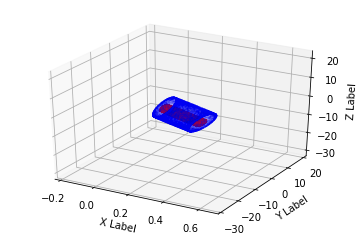

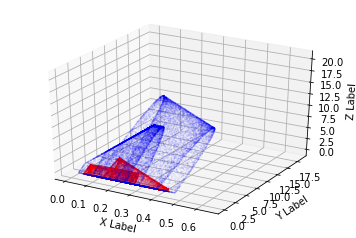

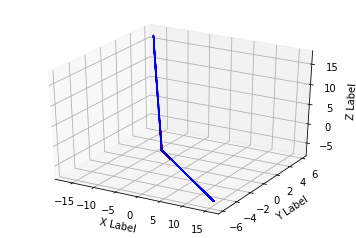

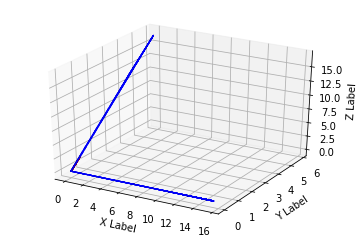

In [145]:
for key in list(rep3d3w.keys())[:-2]:
    transformedpoints = rep3d3w[key].detach()
    dataVisualizer(transformedpoints, y_train)

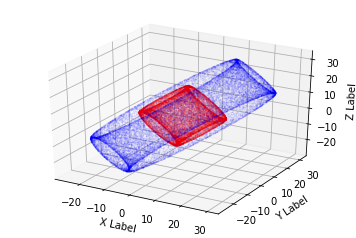

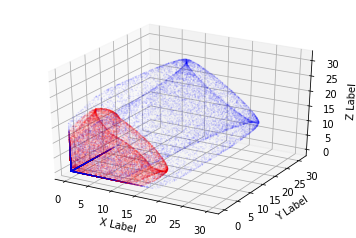

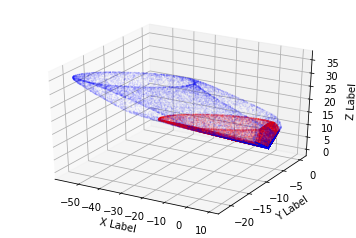

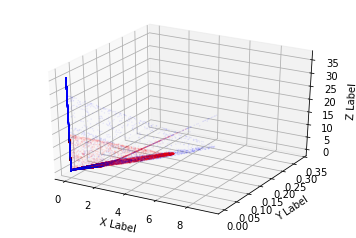

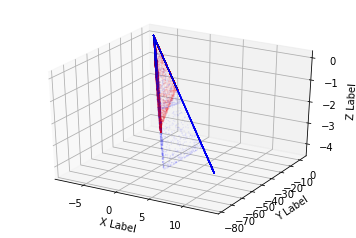

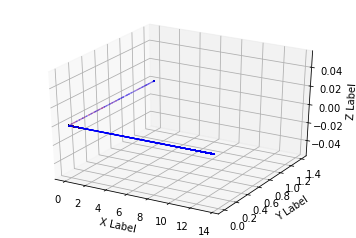

In [146]:
for key in list(rep4d3w.keys())[:-2]:
    transformedpoints = rep4d3w[key].detach()
    dataVisualizer(transformedpoints, y_train)

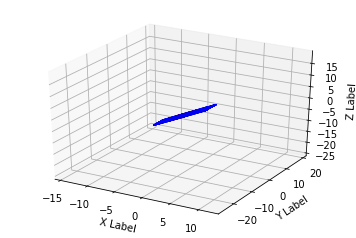

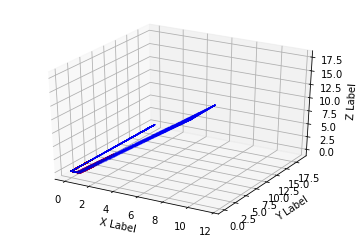

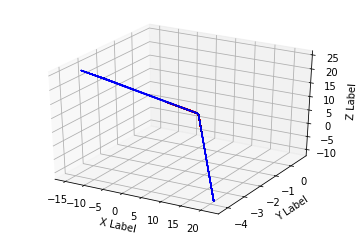

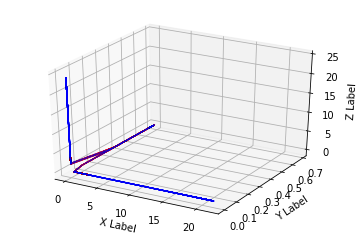

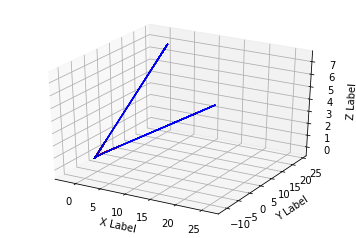

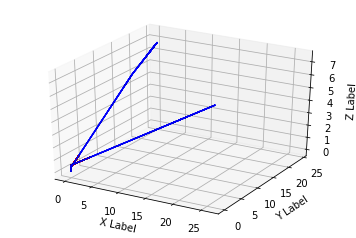

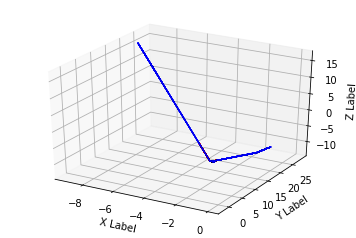

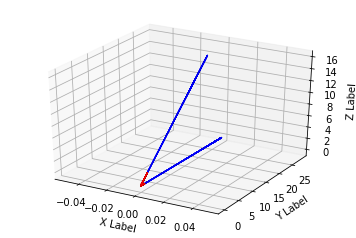

In [147]:
for key in list(rep5d3w.keys())[:-2]:
    transformedpoints = rep5d3w[key].detach()
    dataVisualizer(transformedpoints, y_train)

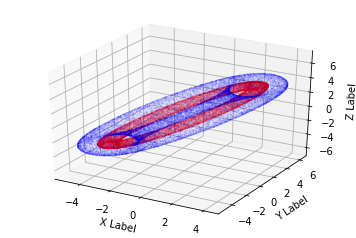

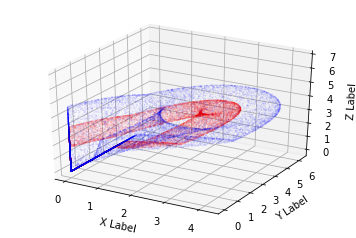

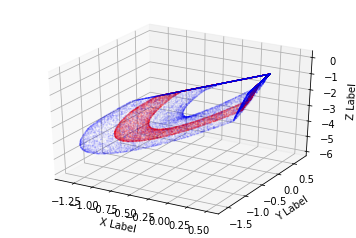

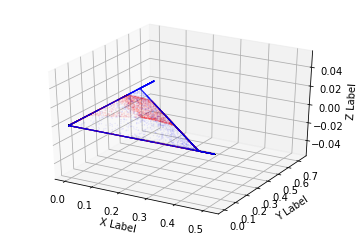

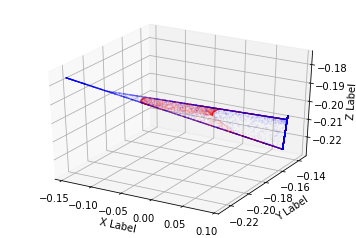

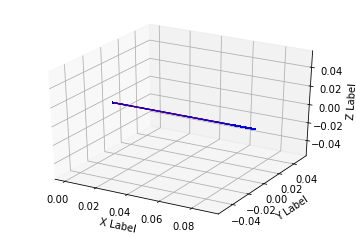

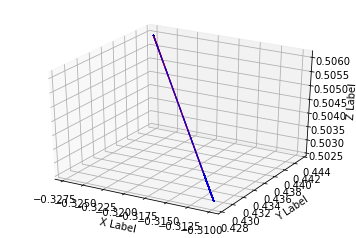

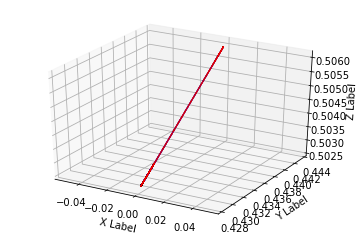

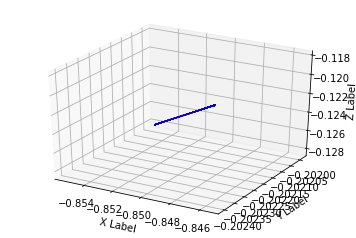

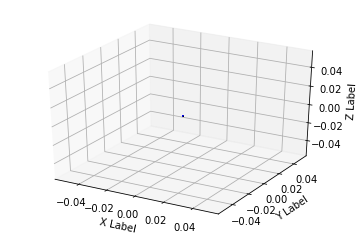

In [148]:
for key in list(rep6d3w.keys())[:-2]:
    transformedpoints = rep6d3w[key].detach()
    dataVisualizer(transformedpoints, y_train)

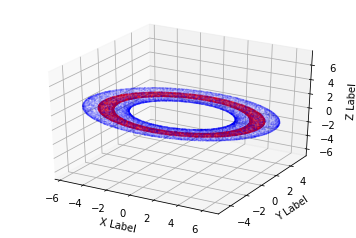

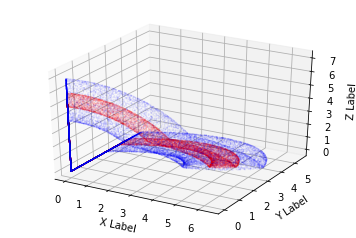

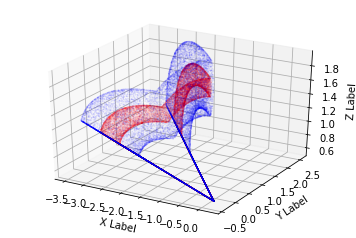

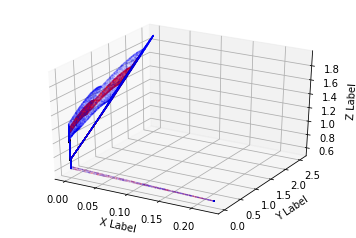

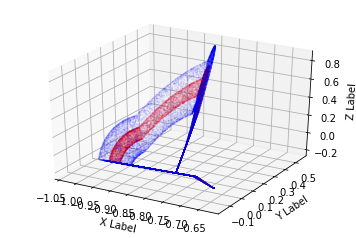

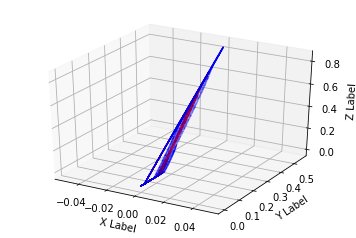

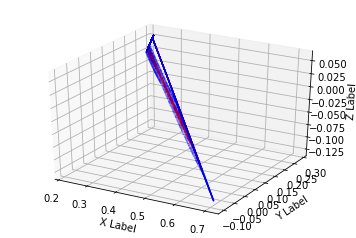

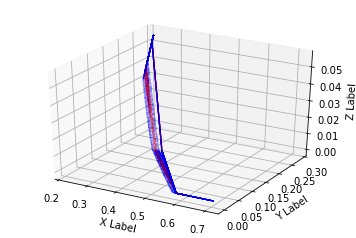

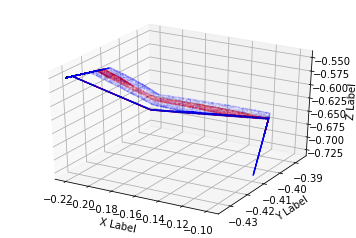

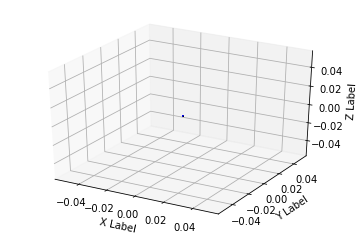

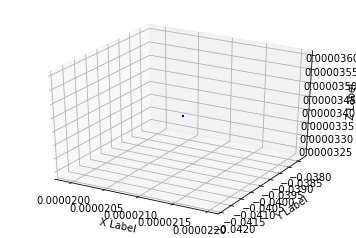

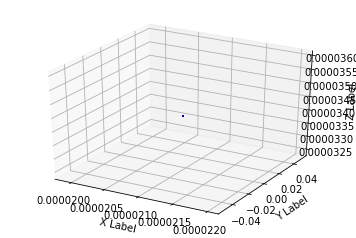

In [149]:
for key in list(rep7d3w.keys())[:-2]:
    transformedpoints = rep7d3w[key].detach()
    dataVisualizer(transformedpoints, y_train)

Finally now the same thing but with the interlinked tori.

In [150]:
net3d3w2 = FullyConnected(width = 3, depth = 3)
net4d3w2 = FullyConnected(width = 3, depth = 4)
net5d3w2 = FullyConnected(width = 3, depth = 5)
net6d3w2 = FullyConnected(width = 3, depth = 6)
net7d3w2 = FullyConnected(width = 3, depth = 7)

In [151]:
print('net3d3w2')
train(net3d3w2, trainloader2)
print('net4d3w2')
train(net4d3w2, trainloader2)
print('net5d3w2')
train(net5d3w2, trainloader2)
print('net6d3w2')
train(net6d3w2, trainloader2)
print('net7d3w2')
train(net7d3w2, trainloader2)

net3d3w2
[1,  1000] loss: 0.194
[1,  2000] loss: 0.082
[1,  3000] loss: 0.072
[1,  4000] loss: 0.178
[1,  5000] loss: 0.116
[1,  6000] loss: 0.068
[1,  7000] loss: 0.077
[1,  8000] loss: 0.093
[1,  9000] loss: 0.058
[1, 10000] loss: 0.054
[1, 11000] loss: 0.145
[1, 12000] loss: 0.132
[1, 13000] loss: 0.072
[1, 14000] loss: 0.063
[1, 15000] loss: 0.058
[2,  1000] loss: 0.082
[2,  2000] loss: 0.064
[2,  3000] loss: 0.061
[2,  4000] loss: 0.075
[2,  5000] loss: 0.057
[2,  6000] loss: 0.065
[2,  7000] loss: 0.071
[2,  8000] loss: 0.131
[2,  9000] loss: 0.170
[2, 10000] loss: 0.186
[2, 11000] loss: 0.107
[2, 12000] loss: 0.097
[2, 13000] loss: 0.194
[2, 14000] loss: 0.126
[2, 15000] loss: 0.136
Finished Training
net4d3w2
[1,  1000] loss: 0.176
[1,  2000] loss: 0.147
[1,  3000] loss: 0.124
[1,  4000] loss: 0.162
[1,  5000] loss: 0.162
[1,  6000] loss: 0.129
[1,  7000] loss: 0.124
[1,  8000] loss: 0.302
[1,  9000] loss: 0.328
[1, 10000] loss: 0.322
[1, 11000] loss: 0.309
[1, 12000] loss: 0.29

In [152]:
rep3d3w2 = {}
rep4d3w2 = {}
rep5d3w2 = {}
rep6d3w2 = {}
rep7d3w2 = {}

def hook_fn_3d3w2(module, inp, out):
    rep3d3w2[module] = out
    
def hook_fn_4d3w2(module, inp, out):
    rep4d3w2[module] = out

def hook_fn_5d3w2(module, inp, out):
    rep5d3w2[module] = out

def hook_fn_6d3w2(module, inp, out):
    rep6d3w2[module] = out

def hook_fn_7d3w2(module, inp, out):
    rep7d3w2[module] = out

    
get_values_from_layers(net3d3w2, hook_fn_3d3w2)
get_values_from_layers(net4d3w2, hook_fn_4d3w2)
get_values_from_layers(net5d3w2, hook_fn_5d3w2)
get_values_from_layers(net6d3w2, hook_fn_6d3w2)
get_values_from_layers(net7d3w2, hook_fn_7d3w2)

net3d3w2(x_train2)
net4d3w2(x_train2)
net5d3w2(x_train2)
net6d3w2(x_train2)
net7d3w2(x_train2)

tensor([[0.6114, 0.3886],
        [0.3561, 0.6439],
        [0.3561, 0.6439],
        ...,
        [0.4919, 0.5081],
        [0.3561, 0.6439],
        [0.3561, 0.6439]], grad_fn=<SoftmaxBackward>)

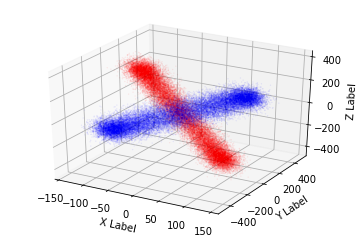

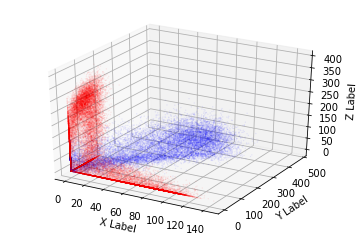

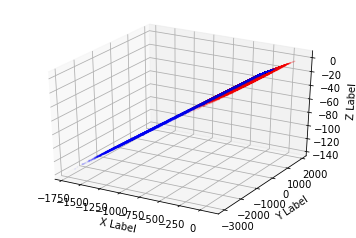

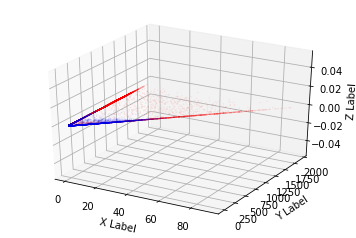

In [153]:
for key in list(rep3d3w2.keys())[:-2]:
    transformedpoints = rep3d3w2[key].detach()
    dataVisualizer(transformedpoints, y_train2)

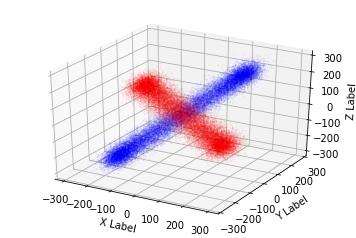

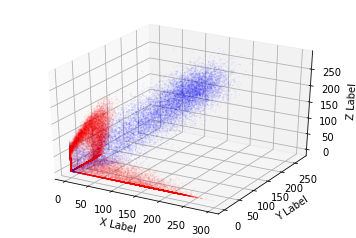

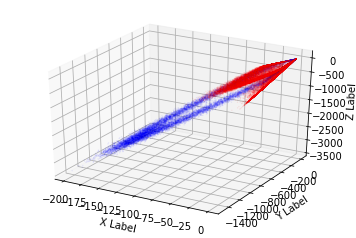

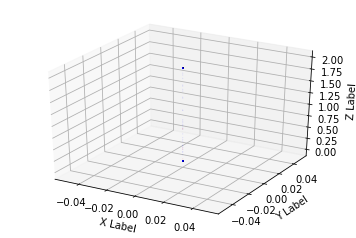

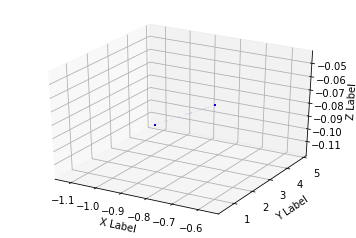

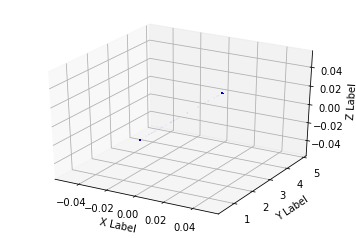

In [154]:
for key in list(rep4d3w2.keys())[:-2]:
    transformedpoints = rep4d3w2[key].detach()
    dataVisualizer(transformedpoints, y_train2)

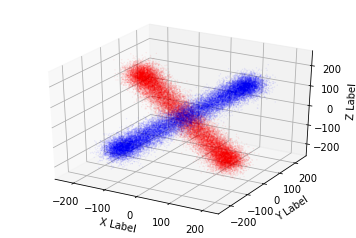

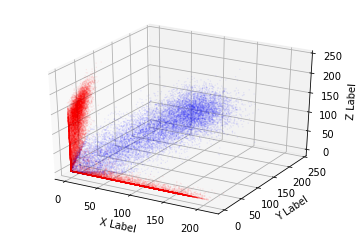

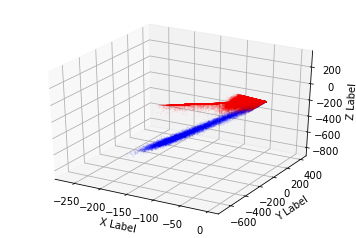

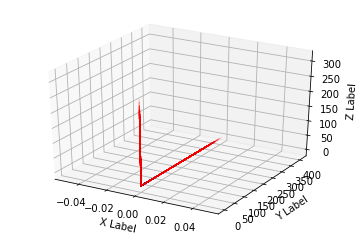

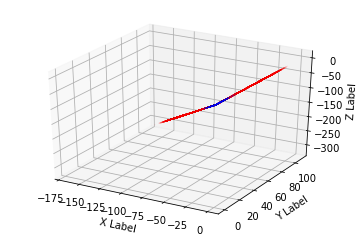

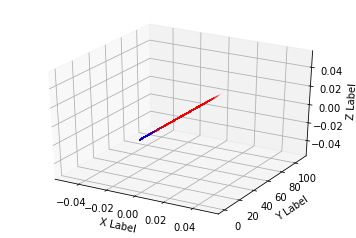

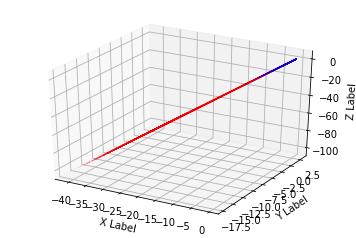

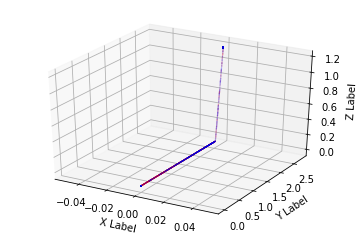

In [155]:
for key in list(rep5d3w2.keys())[:-2]:
    transformedpoints = rep5d3w2[key].detach()
    dataVisualizer(transformedpoints, y_train2)

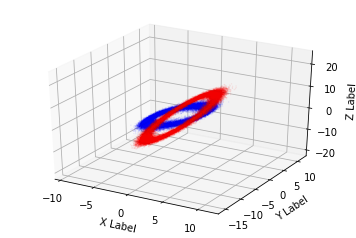

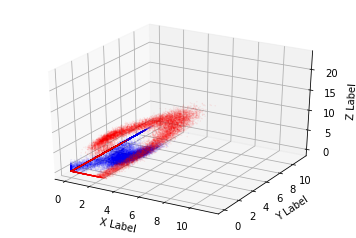

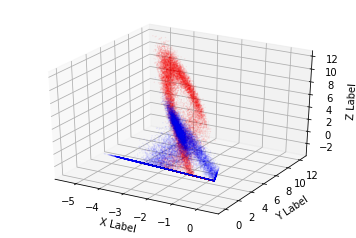

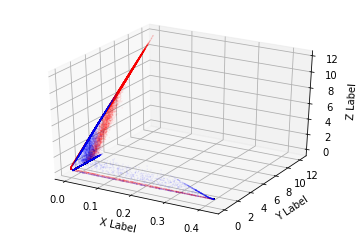

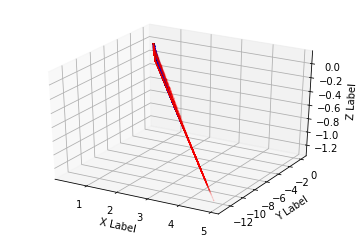

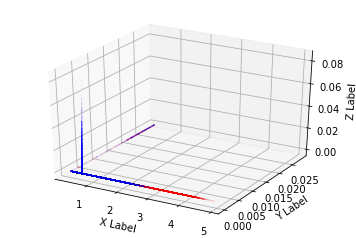

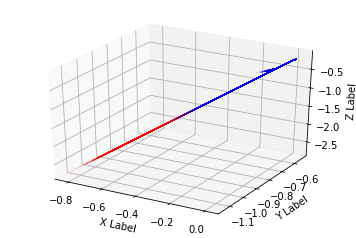

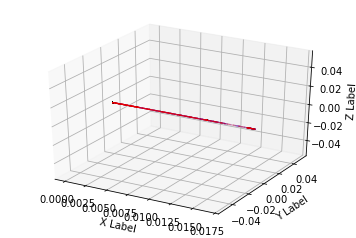

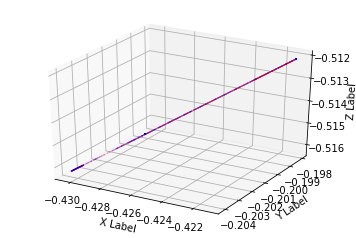

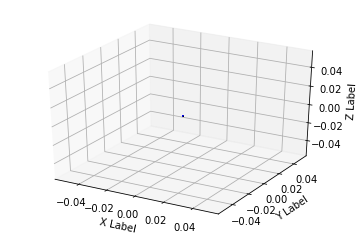

In [156]:
for key in list(rep6d3w2.keys())[:-2]:
    transformedpoints = rep6d3w2[key].detach()
    dataVisualizer(transformedpoints, y_train2)

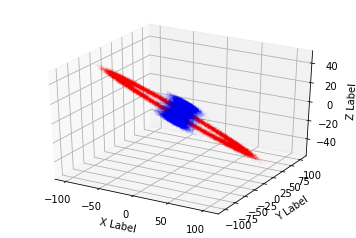

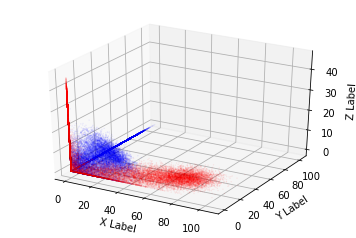

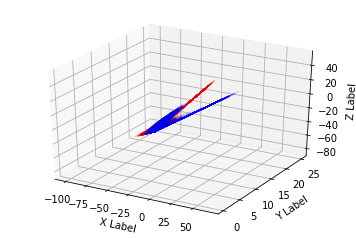

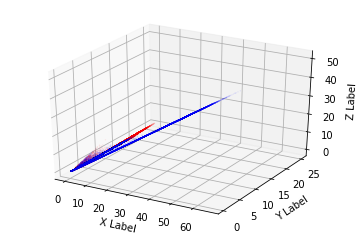

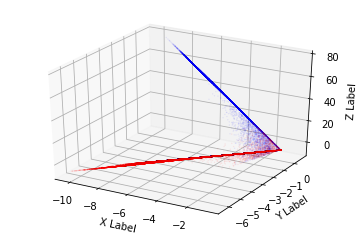

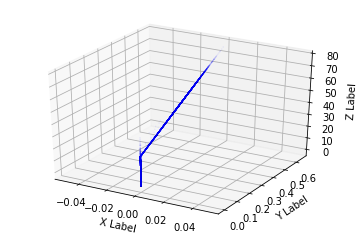

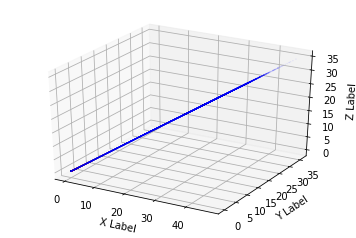

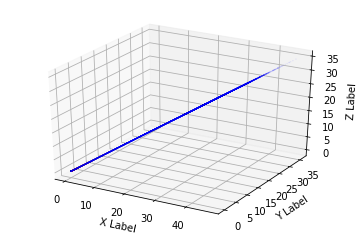

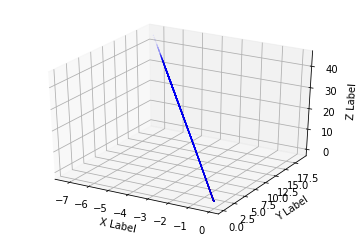

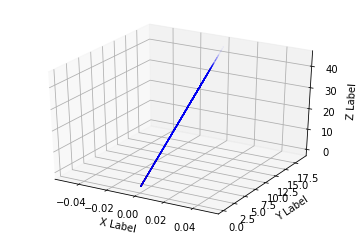

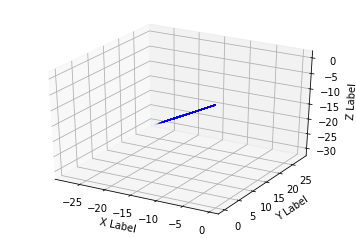

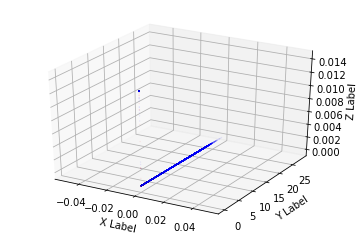

In [157]:
for key in list(rep7d3w2.keys())[:-2]:
    transformedpoints = rep7d3w2[key].detach()
    dataVisualizer(transformedpoints, y_train2)